In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:

# Load data
df_classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename columns for features
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}
colNames = dict(colNames1, **colNames2, **colNames3)
colNames = {int(jj): item_kk for jj, item_kk in colNames.items()}
df_features = df_features.rename(columns=colNames)

# Merge Class and Features
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
df_class_feature = pd.merge(df_classes, df_features)

# Prepare data for GCN
selected_ids = df_class_feature.loc[(df_class_feature['class'] != 3), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids) & df_edges['txId2'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# Merge Class and Features for selected data
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected)

In [33]:
# Prepare node features (X) and labels (y)
X = df_class_feature_selected.drop(columns=['txId', 'class', 'Time step']).values
y = df_class_feature_selected['class'].apply(lambda x: 0 if x == '2' else 1).values

# Prepare edge list for graph
graph = nx.from_pandas_edgelist(df_edges_selected, source='txId1', target='txId2', create_using=nx.DiGraph())

# Convert to PyTorch Geometric Data
edge_index = from_networkx(graph).edge_index
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)

# Split data into train and test
train_mask, test_mask = train_test_split(range(data.num_nodes), test_size=0.25, random_state=15)
data.train_mask = torch.tensor(train_mask, dtype=torch.long)
data.test_mask = torch.tensor(test_mask, dtype=torch.long)

# Define GNN Model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
input_dim = X.shape[1]
hidden_dim = 16
output_dim = 2

model = GNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train GNN Model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test GNN Model
def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / len(data.test_mask)
    return test_acc, pred

In [34]:
# Training loop
losses = []
accuracies = []
for epoch in range(1, 201):
    loss = train()
    losses.append(loss)
    if epoch % 10 == 0:
        acc, _ = test()
        accuracies.append(acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

Epoch: 010, Loss: 0.2861, Test Acc: 0.9083
Epoch: 020, Loss: 0.2215, Test Acc: 0.9169
Epoch: 030, Loss: 0.1992, Test Acc: 0.9394
Epoch: 040, Loss: 0.1807, Test Acc: 0.9465
Epoch: 050, Loss: 0.1700, Test Acc: 0.9522
Epoch: 060, Loss: 0.1592, Test Acc: 0.9556
Epoch: 070, Loss: 0.1553, Test Acc: 0.9595
Epoch: 080, Loss: 0.1489, Test Acc: 0.9613
Epoch: 090, Loss: 0.1452, Test Acc: 0.9624
Epoch: 100, Loss: 0.1407, Test Acc: 0.9645
Epoch: 110, Loss: 0.1392, Test Acc: 0.9645
Epoch: 120, Loss: 0.1353, Test Acc: 0.9675
Epoch: 130, Loss: 0.1314, Test Acc: 0.9701
Epoch: 140, Loss: 0.1312, Test Acc: 0.9706
Epoch: 150, Loss: 0.1292, Test Acc: 0.9718
Epoch: 160, Loss: 0.1277, Test Acc: 0.9723
Epoch: 170, Loss: 0.1244, Test Acc: 0.9722
Epoch: 180, Loss: 0.1228, Test Acc: 0.9717
Epoch: 190, Loss: 0.1252, Test Acc: 0.9724
Epoch: 200, Loss: 0.1195, Test Acc: 0.9738


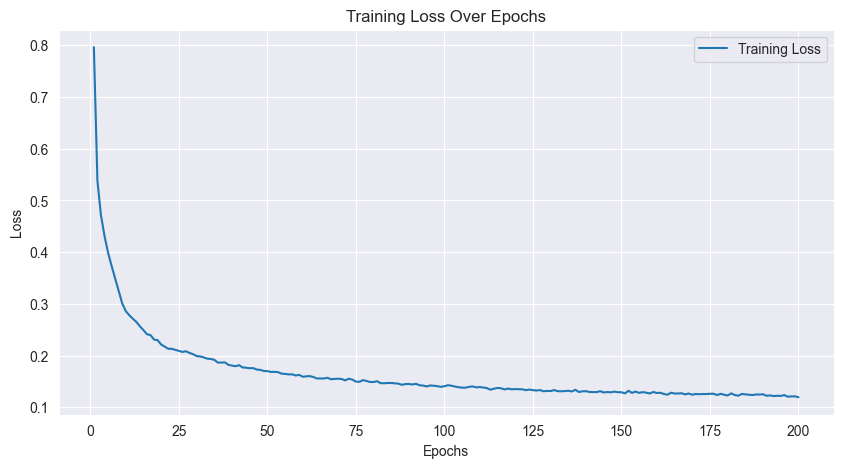

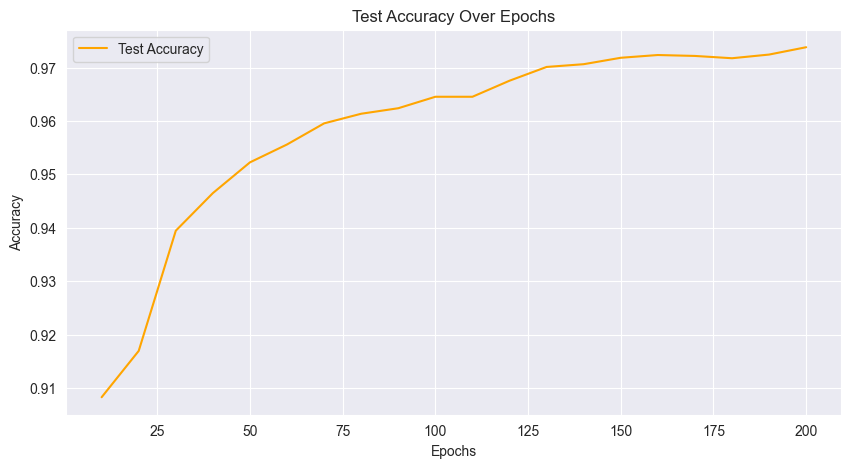

In [35]:

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 201), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(10, 201, 10), accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Accuracy: 0.9738
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10523
           1       0.94      0.78      0.85      1118

    accuracy                           0.97     11641
   macro avg       0.96      0.89      0.92     11641
weighted avg       0.97      0.97      0.97     11641


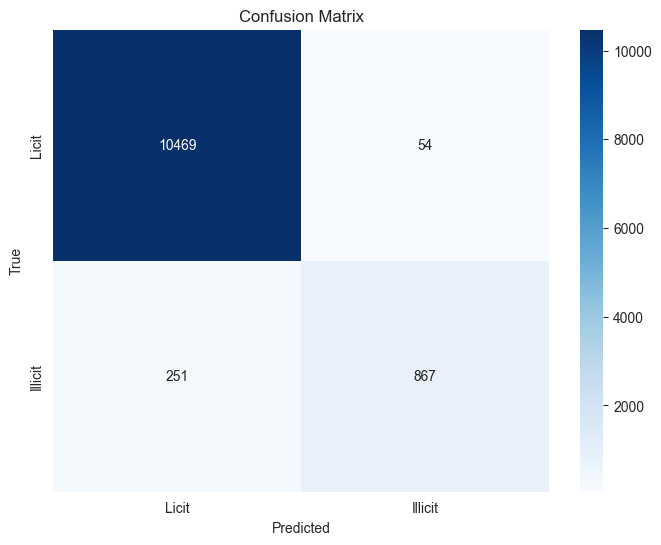

In [36]:

# Evaluate the model
acc, pred = test()
print(f'Final Test Accuracy: {acc:.4f}')

# Classification report
y_true = y[data.test_mask]
y_pred = pred[data.test_mask].numpy()
print(classification_report(y_true, y_pred))

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()